In [1]:
from collections import Counter
from gensim.models import Word2Vec
from nltk import sent_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import PorterStemmer, SnowballStemmer, WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer #for word embedding
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix,precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score,recall_score # bag of words
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
import itertools
import collections
import csv
import gensim
import matplotlib.pyplot as plt
import nltk
import nltk.tokenize
import numpy as np #for text pre-processing
import operator
import pandas as pd
import pathlib
import pickle
import re, string
import seaborn
import string
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('wordnet')#for model-building
ps = PorterStemmer()

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/yasmin/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /home/yasmin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/yasmin/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Functions

In [2]:
def merging_labels_and_sentences(textfile, labelfile):

    # read textfile and labelfile into two separate dataframes
    df_text = pd.read_csv(textfile + '.txt', header=None, skiprows = 0,
        names=['tweet'], sep='\t', quoting=3)
    df_labels = pd.read_csv(labelfile + '.txt',header=None, skiprows = 0, names=['label'],
        sep='\t', quoting=3)

    index_text = [x for x in range(1, len(df_text.values)+1)]

    df_labels.insert(loc=0, column='id', value =index_text)
    df_text.insert(loc=0, column='id', value =index_text)
    final_df = df_text.merge(df_labels, on='id', how='left')

    return final_df

def missing_values(dataframe):
    res = dataframe.isna().sum()
    return res

def word_count(dataframe_col):
    dataframe_col['word_count'] = dataframe_col['tweet'].apply(lambda x: len(str(x).split()))
    
    avg_off_tweets = round(dataframe_col[dataframe_col['label']==1]['word_count'].mean(),3)
    avg_non_off_tweets = round(dataframe_col[dataframe_col['label']==0]['word_count'].mean(),3) 

    return dataframe_col, avg_off_tweets, avg_non_off_tweets
# CHARACTER-COUNT
def char_count(dataframe_col):
    dataframe_col['char_count'] = dataframe_col['tweet'].apply(lambda x: len(str(x)))
    
    #the average characters in offensive tweets
    avg_char_off = round(dataframe_col[dataframe_col['label']==1]['char_count'].mean(),3) 

    #the average characters in non-offensive tweets
    avg_char_non_off = round(dataframe_col[dataframe_col['label']==0]['char_count'].mean(),3)

    return dataframe_col, avg_char_off, avg_char_non_off

def class_distribution(dataframe,title,xlabel_title):
    x = dataframe['label'].value_counts()
    barplot = seaborn.barplot(x.index, x)
    barplot.set_title(title)
    barplot.set_xlabel(xlabel_title)
    barplot.set_ylabel("Count")
 
    return barplot
def plot_word_count(dataframe):
    # PLOTTING WORD-COUNT
    fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,4))
    dataframe_words=dataframe[dataframe['label']==1]['word_count']
    ax1.hist(dataframe_words,color='red')
    ax1.set_title('offensive tweets')
    dataframe_words=dataframe[dataframe['label']==0]['word_count']
    ax2.hist(dataframe_words,color='green')
    ax2.set_title('non-offensive tweets')
    fig.suptitle('Words per tweet')
    ax2.set_xlabel("Length of tweet")
    ax2.set_ylabel("occurrences")
    ax1.set_xlabel("Length of tweet")
    ax1.set_ylabel("occurrences")
    fig.savefig('word_count_plot.png')
    plt.show()

def split_dataset(dataframe):
    X_train, X_test, y_train, y_test = train_test_split(dataframe["tweet"],dataframe      
    ["label"],test_size=0.2,shuffle=True)
    return X_train, X_test, y_train, y_test
def tokenize_train_test(X_train, X_test):
    #Word2Vec
    # Word2Vec runs on tokenized sentences
    X_train_tok= [nltk.word_tokenize(i) for i in X_train]  
    X_test_tok= [nltk.word_tokenize(i) for i in X_test]

    return X_train_tok, X_test_tok
#building Word2Vec model
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = len(next(iter(word2vec.values())))

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([np.mean([self.word2vec[w] 
        for w in words if w in self.word2vec] or [np.zeros(self.dim)], axis=0) 
        for words in X])
def create_bag_of_words(X):

    print ('Creating bag of words...')
    # Initialize the "CountVectorizer" object, which is scikit-learn's
    # bag of words tool.  
    
    # In this example features may be single words or two consecutive words
    vectorizer = CountVectorizer(analyzer = "word",   \
                                 tokenizer = None,    \
                                 preprocessor = None, \
                                 stop_words = None,   \
                                 ngram_range = (1,2), \
                                 max_features = 10000) 

    # fit_transform() does two functions: First, it fits the model
    # and learns the vocabulary; second, it transforms our training data
    # into feature vectors. The input to fit_transform should be a list of 
    # strings. The output is a sparse array
    train_data_features = vectorizer.fit_transform(X)
    
    # Convert to a NumPy array for easy of handling
    train_data_features = train_data_features.toarray()
    
    # tfidf transform
    
    tfidf = TfidfTransformer()
    tfidf_features = tfidf.fit_transform(train_data_features).toarray()

    # Take a look at the words in the vocabulary
    vocab = vectorizer.get_feature_names()
   
    return vectorizer, vocab, train_data_features, tfidf_features, tfidf
def train_logistic_regression(features, label):
    print ("Training the logistic regression model...")

    ml_model = LogisticRegression(C = 100,random_state = 0)
    ml_model.fit(features, label)
    print ('Finished')
    return ml_model



def get_word2vec_embeddings(vectors, clean_questions_tokens, generate_missing=False):
    embeddings = clean_questions_tokens.apply(lambda x: get_average_word2vec(x, vectors, 
                                                                                generate_missing=generate_missing))
    return list(embeddings)


def get_metrics(y_test, y_predicted):  
    # true positives / (true positives+false positives)
    precision = precision_score(y_test, y_predicted, pos_label=None,
                                    average='weighted')             
    # true positives / (true positives + false negatives)
    recall = recall_score(y_test, y_predicted, pos_label=None,
                              average='weighted')
    
    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')
    
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.winter):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", 
                 color="white" if cm[i, j] < thresh else "black", fontsize=40)
    
    plt.tight_layout()
    plt.ylabel('True label', fontsize=30)
    plt.xlabel('Predicted label', fontsize=30)
    plt.savefig('confusion_matrix' + title +'.png')
    return plt




# Task 04

# Offensive dataset

## Training

In [3]:
train_df = merging_labels_and_sentences('datasets/offensive/train_text', 'datasets/offensive/train_labels')

In [4]:
missing_val = missing_values(train_df)
# Average words devided into labels
avg_labels_word = word_count(train_df)
avg_labels_char = char_count(train_df)

print(' Average Number of Words - Offensive Tweets: ', avg_labels_word[1],'\n','Average Number of Words - Non-offensive Tweets: ', avg_labels_word[2])
print(' Average Characters in Offensive Tweets: ', avg_labels_char[1],'\n','Average Characters in Non-offensive Tweets: ', avg_labels_char[2])

print('\nNumber of missing values for each column\n',missing_val)

 Average Number of Words - Offensive Tweets:  23.256 
 Average Number of Words - Non-offensive Tweets:  21.411
 Average Characters in Offensive Tweets:  131.836 
 Average Characters in Non-offensive Tweets:  122.761

Number of missing values for each column
 id       0
tweet    0
label    0
dtype: int64


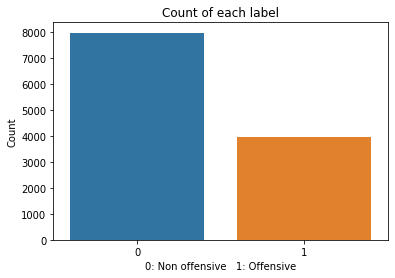

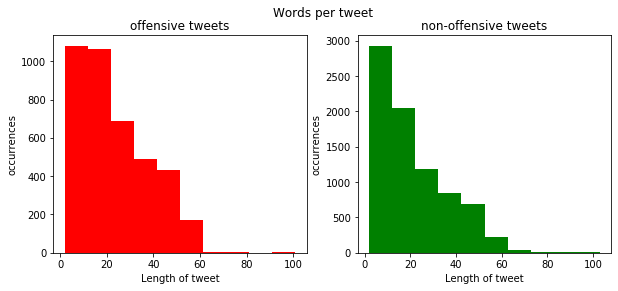

In [5]:
# Number of total labels for each class: 0 = non offensive, 1 = offensive
barplot = class_distribution(train_df,"Count of each label","0: Non offensive   1: Offensive")
# Histogram of Word count pr tweet
plot_word_count = plot_word_count(train_df)




## Testing

In [6]:
test_df = merging_labels_and_sentences('datasets/offensive/test_text', 'datasets/offensive/test_labels')

## Term Frequency-Inverse Document Frequencies


Term Frequency-Inverse Document Frequencies (tf-Idf): Count vectors might not be the best representation for converting text data to numerical data. So, instead of simple counting, we can also use an advanced variant of the Bag-of-Words that uses the term frequency–inverse document frequency (or Tf-Idf). Basically, the value of a word increases proportionally to count in the document, but it is inversely proportional to the frequency of the word in the corpus

In [7]:
train_df

,id,tweet,label,word_count,char_count
0,1,@user Bono... who cares. Soon people will unde...,0,31,193
1,2,@user Eight years the republicans denied obama...,1,17,114
2,3,@user Get him some line help. He is gonna be j...,0,44,222
3,4,@user @user She is great. Hi Fiona!,0,7,36
4,5,@user She has become a parody unto herself? Sh...,1,32,189
...,...,...,...,...,...
11911,11912,@user I wonder if they are sex traffic victims?,1,9,48
11912,11913,@user Do we dare say he is... better than Nyjer?,0,10,49
11913,11914,@user No idea who he is. Sorry,0,7,31
11914,11915,#Professor Who Shot Self Over Trump Says Gun C...,0,13,76


## Here we are splitting the data

In [8]:
X_train = train_df['tweet']
y_train = train_df['label']
X_test = test_df["tweet"]
y_test = test_df["label"]

# Feature extraction

In [9]:
# Here we tokenize the data
X_train_tok, X_test_tok = tokenize_train_test(X_train, X_test)


# (tf-Idf)
tfidf_vectorizer = TfidfVectorizer(use_idf=True)
X_train_vectors_tfidf = tfidf_vectorizer.fit_transform(X_train) 
X_test_vectors_tfidf = tfidf_vectorizer.transform(X_test)

# (#W2v)
w2v_X_train_tok=[nltk.word_tokenize(i) for i in X_train]
model = gensim.models.Word2Vec(w2v_X_train_tok,min_count=1)
w2v = dict(zip(model.wv.index_to_key, model.wv))      
modelw = MeanEmbeddingVectorizer(w2v)


# converting text to numerical data using Word2Vec
X_train_vectors_w2v = modelw.transform(X_train_tok)
X_test_vectors_w2v = modelw.transform(X_test_tok)

## Bag of words with tf-idf

In [10]:
vectorizer, vocab, train_data_features, tfidf_features, tfidf  = (
        create_bag_of_words(X_train))

Creating bag of words...


In [11]:
ml_model = train_logistic_regression(tfidf_features, y_train)

Training the logistic regression model...
/home/yasmin/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
Finished


In [12]:
test_data_features = vectorizer.transform(X_test)
# Convert to numpy array
test_data_features = test_data_features.toarray()

In [13]:
predicted_y = ml_model.predict(test_data_features)

In [14]:
correctly_identified_y = predicted_y == y_test
accuracy = np.mean(correctly_identified_y) * 100
accuracy, precision, recall, f1 = get_metrics(y_test, predicted_y)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.503, precision = 0.734, recall = 0.503, f1 = 0.506


### Summary 

Testing the Bag of Words implementation combined with tf-idf in the model for Logistic Regression shows Accuracy at _0.50 or 50 %_ and therefore we decided to not test the BOW + tf-idf on other classifier models since BOW + w2v gives much better results for all classifiers (logistic regression, linear svc, naive bayes, random forest)

## Bag of Words - Word2Vec

***

#### Creating the model 

In [15]:
count_vectorizer = CountVectorizer(analyzer='word', token_pattern=r'\w+')

bow = dict()
bow["train"] = (count_vectorizer.fit_transform(X_train), y_train)
bow["test"]  = (count_vectorizer.transform(X_test), y_test)

#### Classifers and imports

In [16]:

from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier


#log reg
lr_classifier = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', random_state=40)

#linear svc
lsvm_classifier = LinearSVC(C=1.0, class_weight='balanced', multi_class='ovr', random_state=40)

#naive bayes
nb_classifier = MultinomialNB()

#random forest 
clf_bow = RandomForestClassifier(n_estimators = 40)

#data set in bag of words
embedding = bow

#### a) Classifier: Logistic Regression

In [17]:
classifier = lr_classifier     
# lr_classifier 

classifier.fit(*embedding["train"])
y_predict = classifier.predict(embedding["test"][0])

accuracy, precision, recall, f1 = get_metrics(embedding["test"][1], y_predict)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))


cm = confusion_matrix(embedding["test"][1], y_predict)
fig = plt.figure(figsize=(10, 10))
#plot = plot_confusion_matrix(cm, classes=['Non-Offensive','Offensive'], normalize=False, title='Confusion matrix')
#plt.show()


accuracy = 0.748, precision = 0.747, recall = 0.748, f1 = 0.748


<Figure size 720x720 with 0 Axes>

#### b) Classifier: Linear Support Vector Machine

In [18]:
classifier = lsvm_classifier    
# lsvm_classifier 

classifier.fit(*embedding["train"])
y_predict = classifier.predict(embedding["test"][0])

accuracy, precision, recall, f1 = get_metrics(embedding["test"][1], y_predict)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))


cm = confusion_matrix(embedding["test"][1], y_predict)
fig = plt.figure(figsize=(10, 10))
#plot = plot_confusion_matrix(cm, classes=['Non-Offensive','Offensive'], normalize=False, title='Confusion matrix')
#plt.show()

accuracy = 0.755, precision = 0.754, recall = 0.755, f1 = 0.754
/home/yasmin/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


<Figure size 720x720 with 0 Axes>

#### C) Classifier: Naive Bayes

In [19]:

classifier = nb_classifier    
# lr_classifier | lsvm_classifier | nb_classifier

classifier.fit(*embedding["train"])
y_predict = classifier.predict(embedding["test"][0])

accuracy, precision, recall, f1 = get_metrics(embedding["test"][1], y_predict)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))


cm = confusion_matrix(embedding["test"][1], y_predict)
fig = plt.figure(figsize=(10, 10))
#plot = plot_confusion_matrix(cm, classes=['Non-Offensive','Offensive'], normalize=False, title='Confusion matrix')
#plt.show()

accuracy = 0.784, precision = 0.778, recall = 0.784, f1 = 0.780


<Figure size 720x720 with 0 Axes>

#### d) Classifier: Random Forest Classifier

In [20]:

classifier = clf_bow    
# lr_classifier | lsvm_classifier | nb_classifier

classifier.fit(*embedding["train"])
y_predict = classifier.predict(embedding["test"][0])

accuracy, precision, recall, f1 = get_metrics(embedding["test"][1], y_predict)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))


cm = confusion_matrix(embedding["test"][1], y_predict)
fig = plt.figure(figsize=(10, 10))
#plot = plot_confusion_matrix(cm, classes=['Non-Offensive','Offensive'], normalize=False, title='Confusion matrix')
#plt.show()

accuracy = 0.809, precision = 0.813, recall = 0.809, f1 = 0.784


<Figure size 720x720 with 0 Axes>

### Summary

Random Forest Classifier with Bag of Words as input gives the best results compared to the other models:
 
- Accuracy at _0.801 or 80 %_ 
- Recall value at _0.801 or 80 %_ 
- F1-score at _0.773 or 77 %_

# Binary classification

***

## Classifier Models

## Stochastic Logistic Regression (sgdc)

1. Feature Extraction Technique: tf-idf
2. Feature Extraction Technique: w2v

#### 1) sgdc with tf-idf

In [21]:
#Use classification algorithm (i.e. Stochastic Logistic Regression) 
from sklearn.linear_model import SGDClassifier

lr_sgdc_tf = SGDClassifier(loss='log', penalty='l1')
lr_sgdc_tf.fit(X_train_vectors_tfidf, y_train)

print(lr_sgdc_tf.score(X_train_vectors_tfidf, y_train))



0.7838200738502853


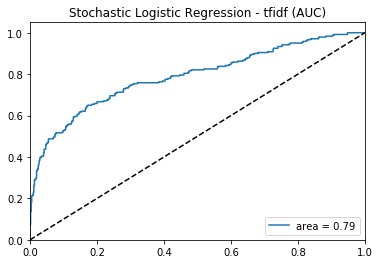

In [22]:
#Create ROC curve
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

pred_probas_lr_sgdc_tf = lr_sgdc_tf.predict_proba(X_test_vectors_tfidf)[:,1]
fpr_lr_sgdc_tf, tpr_lr_sgdc_tf,  thresholds_lr_sgdc_tf= roc_curve(y_test, pred_probas_lr_sgdc_tf)

roc_auc_lr_sgdc_tf = auc(fpr_lr_sgdc_tf,tpr_lr_sgdc_tf)
plt.plot(fpr_lr_sgdc_tf,tpr_lr_sgdc_tf,label='area = %.2f' %roc_auc_lr_sgdc_tf)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('Stochastic Logistic Regression - tfidf (AUC)')
plt.legend(loc="lower right")
plt.savefig('auc_sdgc_tfidf.png')

#### 2) sgdc wit w2v

In [23]:
# Stochastic Logistic Regression) 
from sklearn.linear_model import SGDClassifier

lr_sgdc_w2v = SGDClassifier(loss='log', penalty='l1')
lr_sgdc_w2v.fit(X_train_vectors_w2v, y_train)

#Predict y value for test dataset
y_predict_lr_sgdc_w2v = lr_sgdc_w2v.predict(X_test_vectors_w2v)
y_prob_lr_sgdc_w2v = lr_sgdc_w2v.predict_proba(X_test_vectors_w2v)[:,1]

print(classification_report(y_test,y_predict_lr_sgdc_w2v))
print('Confusion Matrix:',confusion_matrix(y_test, y_predict_lr_sgdc_w2v))

              precision    recall  f1-score   support

           0       0.72      1.00      0.84       620
           1       0.50      0.01      0.02       240

    accuracy                           0.72       860
   macro avg       0.61      0.50      0.43       860
weighted avg       0.66      0.72      0.61       860

Confusion Matrix: [[617   3]
 [237   3]]


AUC: 0.5787466397849462


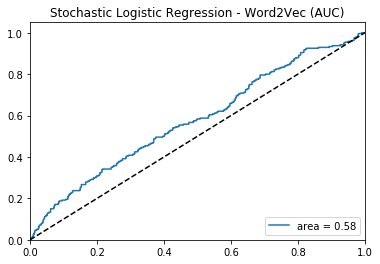

In [24]:
#Create ROC curve
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

pred_probas_lr_sgdc_w2v = lr_sgdc_w2v.predict_proba(X_test_vectors_w2v)[:,1]

# Follwing cant be calculated due to multi-variables:
fpr_lr_sgdc_w2v,tpr_lr_sgdc_w2v,thresholds_lr_sgdc_w2v = roc_curve(y_test, pred_probas_lr_sgdc_w2v)

roc_auc_lr_sgdc_w2v = auc(fpr_lr_sgdc_w2v,tpr_lr_sgdc_w2v)
print('AUC:', roc_auc_lr_sgdc_w2v)
plt.plot(fpr_lr_sgdc_w2v,tpr_lr_sgdc_w2v,label='area = %.2f' %roc_auc_lr_sgdc_w2v)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('Stochastic Logistic Regression - Word2Vec (AUC)')
plt.legend(loc="lower right")
plt.savefig('auc_sdgc_w2v.png')

## Logistic Regression (lr)

1. Feature Extraction Technique: tf-idf
2. Feature Extraction Technique: w2v

#### 1) lr with tf-idf

In [25]:
#FITTING THE CLASSIFICATION MODEL using Logistic Regression(tf-idf)

lr_tfidf=LogisticRegression(solver = 'liblinear', C=10, penalty = 'l2')

lr_tfidf.fit(X_train_vectors_tfidf, y_train)  

#Predict y value for test dataset
y_predict_lr_tfidf = lr_tfidf.predict(X_test_vectors_tfidf)
y_prob_lr_tfidf= lr_tfidf.predict_proba(X_test_vectors_tfidf)[:,1]
print(classification_report(y_test,y_predict_lr_tfidf))
print('Confusion Matrix:',confusion_matrix(y_test, y_predict_lr_tfidf))
 
fpr_lr_tfidf, tpr_lr_tfidf, thresholds_lr_tfidf = roc_curve(y_test, y_prob_lr_tfidf)
roc_auc_lr_tfidf = auc(fpr_lr_tfidf, tpr_lr_tfidf)
print('AUC:', roc_auc_lr_tfidf)

              precision    recall  f1-score   support

           0       0.82      0.92      0.87       620
           1       0.69      0.48      0.57       240

    accuracy                           0.79       860
   macro avg       0.75      0.70      0.72       860
weighted avg       0.78      0.79      0.78       860

Confusion Matrix: [[568  52]
 [125 115]]
AUC: 0.7932224462365591


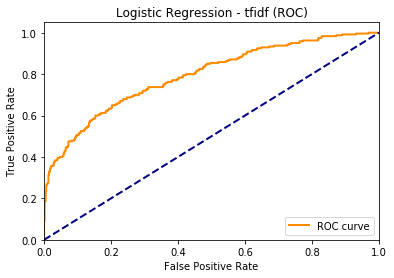

In [26]:
plt.figure()
lw = 2
plt.plot(fpr_lr_tfidf, tpr_lr_tfidf, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression - tfidf (ROC)')
plt.legend(loc="lower right")
plt.savefig('roc_lr_tfidf.png')

#### 2) lr with w2v

In [27]:
#FITTING THE CLASSIFICATION MODEL using Logistic Regression (W2v)

lr_w2v=LogisticRegression(solver = 'liblinear', C=10, penalty = 'l2')
lr_w2v.fit(X_train_vectors_w2v, y_train)  #model

#Predict y value for test dataset
y_predict_lr_w2v = lr_w2v.predict(X_test_vectors_w2v)
y_prob_lr_w2v = lr_w2v.predict_proba(X_test_vectors_w2v)[:,1]

print(classification_report(y_test,y_predict_lr_w2v))
print('Confusion Matrix:',confusion_matrix(y_test, y_predict_lr_w2v))
 
fpr_lr_w2v, tpr_lr_w2v, thresholds_lr_w2v = roc_curve(y_test, y_prob_lr_w2v)
roc_auc_lr_w2v = auc(fpr_lr_w2v, tpr_lr_w2v)
print('AUC:', roc_auc_lr_w2v)

              precision    recall  f1-score   support

           0       0.73      0.99      0.84       620
           1       0.63      0.05      0.09       240

    accuracy                           0.73       860
   macro avg       0.68      0.52      0.47       860
weighted avg       0.70      0.73      0.63       860

Confusion Matrix: [[613   7]
 [228  12]]
AUC: 0.5926512096774192


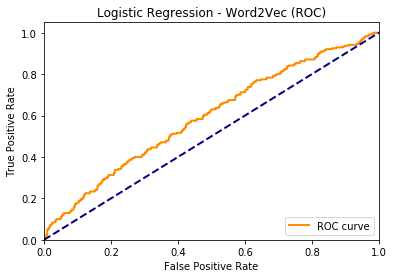

In [28]:
plt.figure()
lw = 2
plt.plot(fpr_lr_w2v, tpr_lr_w2v, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression - Word2Vec (ROC)')
plt.legend(loc="lower right")
plt.savefig('roc_lr_w2v.png')

## Naive Bayes (nb)

1. Feature Extraction Technique: tf-idf
2. Feature Extraction Technique: w2v

In [29]:
#FITTING THE CLASSIFICATION MODEL using Naive Bayes(tf-idf)
nb_tfidf = MultinomialNB()
nb_tfidf.fit(X_train_vectors_tfidf, y_train) 

 #Predict y value for test dataset
y_predict_nb_tfidf= nb_tfidf.predict(X_test_vectors_tfidf)
y_prob_nb_tfidf = nb_tfidf.predict_proba(X_test_vectors_tfidf)[:,1]

print(classification_report(y_test,y_predict_nb_tfidf))
print('Confusion Matrix:',confusion_matrix(y_test, y_predict_nb_tfidf))
 
fpr_nb_tfidf, tpr_nb_tfidf, thresholds_nb_tfidf = roc_curve(y_test, y_prob_nb_tfidf)
roc_auc_nb_tfidf = auc(fpr_nb_tfidf, tpr_nb_tfidf)
print('AUC:', roc_auc_nb_tfidf)

              precision    recall  f1-score   support

           0       0.75      1.00      0.85       620
           1       0.94      0.12      0.22       240

    accuracy                           0.75       860
   macro avg       0.84      0.56      0.54       860
weighted avg       0.80      0.75      0.68       860

Confusion Matrix: [[618   2]
 [210  30]]
AUC: 0.7602990591397849


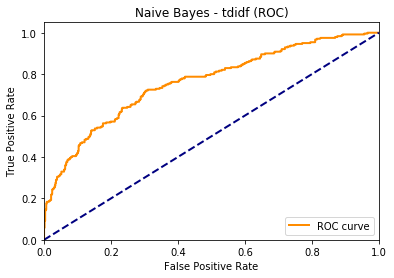

In [30]:
plt.figure()
lw = 2
plt.plot(fpr_nb_tfidf, tpr_nb_tfidf, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Naive Bayes - tdidf (ROC)')
plt.legend(loc="lower right")
plt.savefig('roc_nb_tdidf.png')

#### 2) nb with w2v

In [31]:
#FITTING THE CLASSIFICATION MODEL using Gaussian Naive Bayes(w2v)
from sklearn.naive_bayes import GaussianNB
nb_w2v = GaussianNB()
nb_w2v.fit(X_train_vectors_w2v, y_train) 


 #Predict y value for test dataset
y_predict_nb_w2v = nb_w2v.predict(X_test_vectors_w2v)
y_prob_nb_w2v = nb_w2v.predict_proba(X_test_vectors_w2v)[:,1]

print(classification_report(y_test,y_predict_nb_w2v))
print('Confusion Matrix:',confusion_matrix(y_test, y_predict_nb_w2v))
 
fpr_nb_w2v, tpr_nb_w2v, thresholds_nb_w2v = roc_curve(y_test, y_prob_nb_w2v)
roc_auc_nb_w2v = auc(fpr_nb_w2v, tpr_nb_w2v)
print('AUC:', roc_auc_nb_w2v)

              precision    recall  f1-score   support

           0       0.74      0.43      0.55       620
           1       0.29      0.61      0.40       240

    accuracy                           0.48       860
   macro avg       0.52      0.52      0.47       860
weighted avg       0.62      0.48      0.50       860

Confusion Matrix: [[268 352]
 [ 93 147]]
AUC: 0.5416834677419355


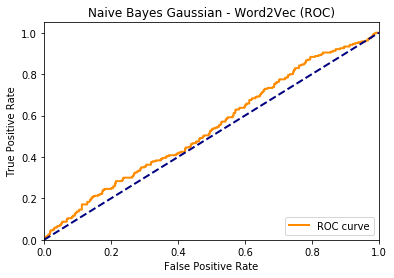

In [32]:
plt.figure()
lw = 2
plt.plot(fpr_nb_w2v, tpr_nb_w2v, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Naive Bayes Gaussian - Word2Vec (ROC)')
plt.legend(loc="lower right")
plt.savefig('roc_nb_w2v.png')

## Random Forest Classifier (clf)

1. Feature Extraction Technique: tf-idf
2. Feature Extraction Technique: w2v

#### 1) clf with tf-idf

In [33]:
#FITTING THE CLASSIFICATION MODEL using RandomForrest (tf-idf)
from sklearn.ensemble import RandomForestClassifier
clf_tfidf = RandomForestClassifier(n_estimators = 100)
clf_tfidf.fit(X_train_vectors_tfidf, y_train) 


 #Predict y value for test dataset
y_predict_clf_tfidf = clf_tfidf.predict(X_test_vectors_tfidf)
y_prob_clf_tfidf = clf_tfidf.predict_proba(X_test_vectors_tfidf)[:,1]

print(classification_report(y_test,y_predict_clf_tfidf))
print('Confusion Matrix:',confusion_matrix(y_test, y_predict_clf_tfidf))
 
fpr_clf_tfidf, tpr_clf_tfidf, thresholds_clf_tfidf = roc_curve(y_test, y_prob_clf_tfidf)
roc_auc_clf_tfidf = auc(fpr_clf_tfidf, tpr_clf_tfidf)
print('AUC:', roc_auc_clf_tfidf)

              precision    recall  f1-score   support

           0       0.80      0.98      0.88       620
           1       0.86      0.37      0.52       240

    accuracy                           0.81       860
   macro avg       0.83      0.67      0.70       860
weighted avg       0.82      0.81      0.78       860

Confusion Matrix: [[605  15]
 [151  89]]
AUC: 0.8114112903225807


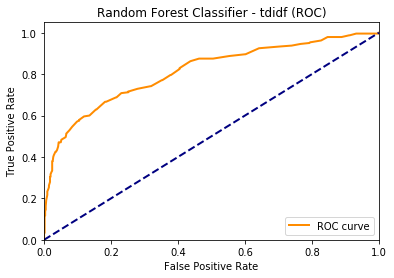

In [34]:
plt.figure()
lw = 2
plt.plot(fpr_clf_tfidf, tpr_clf_tfidf, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest Classifier - tdidf (ROC)')
plt.legend(loc="lower right")
plt.savefig('roc_clf_tfidf.png')

#### 2) clf with w2v

In [35]:
#FITTING THE CLASSIFICATION MODEL using RandomForrest (w2v)
from sklearn.ensemble import RandomForestClassifier
clf_w2v = RandomForestClassifier(n_estimators = 100)
clf_w2v.fit(X_train_vectors_w2v, y_train) 


 #Predict y value for test dataset
y_predict_clf_w2v = clf_w2v.predict(X_test_vectors_w2v)
y_prob_clf_w2v = clf_w2v.predict_proba(X_test_vectors_w2v)[:,1]

print(classification_report(y_test,y_predict_clf_w2v))
print('Confusion Matrix:',confusion_matrix(y_test, y_predict_clf_w2v))
 
fpr_clf_w2v, tpr_clf_w2v, thresholds_clf_w2v = roc_curve(y_test, y_prob_clf_w2v)
roc_auc_clf_w2v = auc(fpr_clf_w2v, tpr_clf_w2v)
print('AUC:', roc_auc_clf_w2v)


              precision    recall  f1-score   support

           0       0.73      0.95      0.82       620
           1       0.36      0.07      0.12       240

    accuracy                           0.71       860
   macro avg       0.54      0.51      0.47       860
weighted avg       0.62      0.71      0.63       860

Confusion Matrix: [[590  30]
 [223  17]]
AUC: 0.5423655913978495


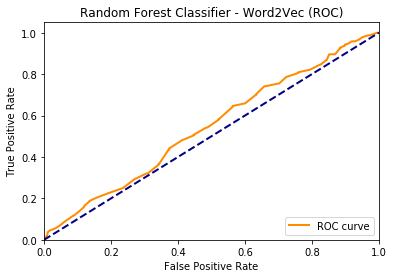

In [36]:
plt.figure()
lw = 2
plt.plot(fpr_clf_w2v, tpr_clf_w2v, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest Classifier - Word2Vec (ROC)')
plt.legend(loc="lower right")
plt.savefig('roc_clf_w2v.png')

# Task 4: Multiclass Classification

_Emoji dataset_

In [37]:
import numpy as np
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC

emoji_df = merging_labels_and_sentences('datasets/emoji/test_text', 'datasets/emoji/test_labels')

X = emoji_df['tweet']
y = emoji_df['label']


In [38]:
# Splitting the dataset into training and testing sets
X_train_em, X_test_em, y_train_em, y_test_em = train_test_split(
    X, y, test_size = 0.1, random_state = 13)

X_train_tok_em= [nltk.word_tokenize(i) for i in X_train_em]  
X_test_tok_em= [nltk.word_tokenize(i) for i in X_test_em]


In [39]:
# creating the model
model_emoji = gensim.models.Word2Vec(X,min_count=1)
w2v_emoji = dict(zip(model_emoji.wv.index_to_key, model_emoji.wv))      
model_emoji.w = MeanEmbeddingVectorizer(w2v_emoji)

# converting text to numerical data using Word2Vec
X_train_vectors_w2v_em = model_emoji.w.transform(X_train_tok_em)
X_test_vectors_w2v_em = model_emoji.w.transform(X_test_tok_em)

## 1) Multiclassification: One vs. Rest Classifier (SVM)

#### 1) SVM with w2v

In [40]:
from sklearn.naive_bayes import GaussianNB
# Creating the SVM model
#model = OneVsRestClassifier(SVC())
emoji_SVM = OneVsRestClassifier(GaussianNB())


# Fitting the model with training data
emoji_SVM.fit(X_train_vectors_w2v_em, y_train_em)
   
# Making a prediction on the test set
prediction_SVM = emoji_SVM.predict(X_test_vectors_w2v_em)
   
# Evaluating the model
print(f"Test Set Accuracy : {accuracy_score(y_test_em, prediction_SVM) * 100} %\n\n")
print(f"Classification Report : \n\n{classification_report(y_test_em, prediction_SVM)}")

Test Set Accuracy : 21.98 %


Classification Report : 

              precision    recall  f1-score   support

           0       0.62      0.66      0.64      1092
           1       0.50      0.00      0.01       476
           2       0.22      0.13      0.16       442
           3       0.08      0.18      0.11       272
           4       0.13      0.08      0.10       358
           5       0.00      0.00      0.00       170
           6       0.05      0.05      0.05       208
           7       0.09      0.20      0.13       258
           8       0.00      0.00      0.00       180
           9       0.07      0.04      0.05       126
          10       0.07      0.38      0.12       127
          11       0.06      0.21      0.09       202
          12       0.11      0.08      0.09       129
          13       0.09      0.01      0.02       108
          14       0.06      0.03      0.04       116
          15       0.00      0.00      0.00       126
          16       0.00  

## 2) Multiclassificarion: One vs. One Classifier (SVC)

#### 1) SVG with w2v

In [41]:

from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsOneClassifier
from sklearn.svm import LinearSVC

emoji_SVC = OneVsOneClassifier(GaussianNB())


# Fitting the model with training data
emoji_SVC.fit(X_train_vectors_w2v_em, y_train_em)
   
# Making a prediction on the test set
prediction_SVC = emoji_SVC.predict(X_test_vectors_w2v_em)
   
# Evaluating the model
print(f"Test Set Accuracy : {accuracy_score(y_test_em, prediction_SVC) * 100} %\n\n")

print(f"Classification Report : \n\n{classification_report(y_test_em, prediction_SVC)}")

Test Set Accuracy : 16.580000000000002 %


Classification Report : 

              precision    recall  f1-score   support

           0       0.55      0.37      0.44      1092
           1       0.50      0.00      0.01       476
           2       0.21      0.13      0.16       442
           3       0.08      0.18      0.11       272
           4       0.12      0.08      0.10       358
           5       0.00      0.00      0.00       170
           6       0.05      0.05      0.05       208
           7       0.09      0.19      0.12       258
           8       0.00      0.00      0.00       180
           9       0.06      0.04      0.05       126
          10       0.08      0.43      0.13       127
          11       0.06      0.21      0.09       202
          12       0.13      0.43      0.20       129
          13       0.07      0.01      0.02       108
          14       0.05      0.03      0.04       116
          15       0.00      0.00      0.00       126
          16

In [98]:

# (tf-Idf)
tfidf_vectorizer = TfidfVectorizer(use_idf=True)
X_train_vectors_tfidf_em = tfidf_vectorizer.fit_transform(X_train_em) 
X_test_vectors_tfidf_em = tfidf_vectorizer.transform(X_test_em)

X_train_vectors_tfidf_em = np.asarray(X_train_vectors_tfidf_em).ravel()
X_test_vectors_tfidf_em = np.asarray(X_test_vectors_tfidf_em).ravel()

In [99]:
bow_emoji = create_bag_of_words(emoji_df)

Creating bag of words...


In [149]:


tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2), 
                        stop_words='english')

# We transform each complaint into a vector
features = tfidf.fit_transform(emoji_df['tweet']).toarray()

labels = emoji_df['label']

print("Each of the %d tweet is represented by %d features (TF-IDF score of unigrams and bigrams)" %(features.shape))



Each of the 50000 tweet is represented by 11329 features (TF-IDF score of unigrams and bigrams)


In [146]:
X = emoji_df['tweet'] # Collection of documents
y = emoji_df['label'] # Target or the labels we want to predict (i.e., the 13 different complaints of products)

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25,
                                                    random_state = 0)


In [108]:
import pandas as pd
import numpy as np
from scipy.stats import randint
import seaborn as sns # used for plot interactive graph. 
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics

In [106]:
models = [
    OneVsOneClassifier(GaussianNB()),
    OneVsRestClassifier(estimator=10),
]

# 5 Cross-validation
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))



In [141]:
X_train_em = np.array(X_train_em)
X_test_em = np.array(X_test_em)
y_train_em = np.array(y_train_em)
y_test_em = np.array(y_test_em)

In [143]:
class DenseTransformer(TransformerMixin):

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return X.todense()


NameError: name 'TransformerMixin' is not defined

In [157]:
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.multiclass import OneVsRestClassifier


classifier = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', OneVsRestClassifier(GaussianNB()))])
classifier.fit(emoji_df[0], emoji_df.values[1])


KeyError: 0

In [ ]:
predicted = classifier.predict(X_test)
for item, labels in zip(X_test, predicted):
    print '%s => %s' % (item, ', '.join(target_names[x] for x in labels))

## 3) kNN for Multiclassification

#### 1) kNN with w2v

In [42]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_recall_fscore_support
neigh_knn = KNeighborsClassifier(n_neighbors=3)
neigh_knn.fit(X_train_vectors_w2v_em, y_train_em)
pred_knn = neigh_knn.predict(X_test_vectors_w2v_em)
print(f"Test Set Accuracy : {accuracy_score(y_test_em, pred_knn) * 100} %\n\n")
print(f"Classification Report : \n\n{classification_report(y_test_em, pred_knn)}")

Test Set Accuracy : 23.52 %


Classification Report : 

              precision    recall  f1-score   support

           0       0.54      0.69      0.60      1092
           1       0.13      0.24      0.17       476
           2       0.13      0.18      0.15       442
           3       0.06      0.05      0.05       272
           4       0.09      0.16      0.12       358
           5       0.05      0.05      0.05       170
           6       0.06      0.03      0.04       208
           7       0.10      0.13      0.11       258
           8       0.06      0.01      0.02       180
           9       0.04      0.01      0.01       126
          10       0.28      0.17      0.21       127
          11       0.02      0.00      0.01       202
          12       0.17      0.20      0.19       129
          13       0.00      0.00      0.00       108
          14       0.00      0.00      0.00       116
          15       0.15      0.02      0.03       126
          16       0.00  

In [43]:
!pip install pydot

In [44]:
!pip install graphviz

In [45]:
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers.merge import Concatenate

import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt

In [46]:
from keras.utils import plot_model
import pydot
import graphviz


In [48]:
plot_model(emoji_SVC, to_file='model_plot4b.png', show_shapes=True, show_layer_names=True)

AttributeError: 'OneVsOneClassifier' object has no attribute 'layers'